# Importaciones

In [1]:
# Importaciones
import pandas as pd
import os
from pathlib import Path
import numpy as np
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
import scipy.stats as stats
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.utils import resample

# Datos

In [2]:
# Importamos los datos
notebook_path = os.path.abspath('')
current_dir = Path(notebook_path)
# Asegúrate de que esta ruta sea la correcta para tu estructura de carpetas
data_dir = current_dir.parent / 'archivos' / 'archivos_formateados'

ruta_luz = data_dir / 'precio-luz-conformato.csv'
ruta_eolica = data_dir / 'generacion-eolica-conformato.csv'
ruta_solar = data_dir / 'generacion-solar-conformato.csv'
ruta_demanda = data_dir / 'demanda-real-conformato.csv'

precio_luz = pd.read_csv(ruta_luz)
generacion_eolica = pd.read_csv(ruta_eolica)
generacion_solar = pd.read_csv(ruta_solar)
demanda_real = pd.read_csv(ruta_demanda)

Para dar formato a los DataSets hacemos lo siguiente:
- Marcamos una fecha de final por si los datos no acban en el mismo día
- Introducimos un desfase en las varaibles exógenas para evitar el data leaking en el modelo
- Añadimos otras variables como la media diaria y su desviación, la hora anterior, del día previo, etc.
- Añadimos medias móviles y std para las variables precio, generaciones y demanda (esta parte es un modelo distinto, comentar si no lo queremos)

In [3]:
# Marcamos una fecha de fin por si los conjuntos terminan en días distintos
fecha_fin = pd.to_datetime('2025-06-30T23:00:00+02:00').tz_convert('UTC')

# Función para formatear los DataFrames
def process_time_series_df(df, value_col, end_date):
    df['datetime'] = pd.to_datetime(df['datetime'], utc=True)
    df = df.set_index('datetime').asfreq('h')
    df[value_col] = pd.to_numeric(df[value_col], errors='coerce')
    return df.loc[:end_date].dropna(subset=[value_col])

precio_luz = process_time_series_df(precio_luz, 'precio', fecha_fin)
generacion_eolica = process_time_series_df(generacion_eolica, 'generacion', fecha_fin)
generacion_solar = process_time_series_df(generacion_solar, 'generacion', fecha_fin)
demanda_real = process_time_series_df(demanda_real, 'demanda', fecha_fin)

df = precio_luz.copy()
df['generacion_eolica'] = generacion_eolica['generacion'].shift(24)
df['generacion_solar'] = generacion_solar['generacion'].shift(24)
df['demanda_real'] = demanda_real['demanda'].shift(24)
df = df.dropna()

# Creamos los features adicionales del modelo
def create_features(df):
    df = df.copy()
    df['hora'] = df.index.hour
    df['dia_semana'] = df.index.dayofweek
    df['mes'] = df.index.month
    # df['lag_1'] = df['precio'].shift(1)
    # df['lag_24'] = df['precio'].shift(24)
    # df['lag_168'] = df['precio'].shift(168)
    df['rolling_mean_24'] = df['precio'].rolling(24).mean()
    df['rolling_std_24'] = df['precio'].rolling(24).std()
    df['rolling_mean_24_eolica'] = df['generacion_eolica'].rolling(24).mean()
    df['rolling_std_24_eolica'] = df['generacion_eolica'].rolling(24).std()
    df['rolling_mean_24_solar'] = df['generacion_solar'].rolling(24).mean()
    df['rolling_std_24_solar'] = df['generacion_solar'].rolling(24).std()
    df['rolling_mean_24_demanda'] = df['demanda_real'].rolling(24).mean()
    df['rolling_std_24_demanda'] = df['demanda_real'].rolling(24).std()
    return df.dropna()

df_feat = create_features(df)

Vamos a definir los conjuntos sobre los que operaremos:
- Fijamos un conjunto de predicción sobre el que realizaremos un forecasting con el modelo entrenado
- Train y test set, que abarcan un 95/5% de los datos restantes

In [4]:
# Generamos un conjunto sobre el que haremos la predicción, eligiendo las fechas de inicio y fin
intervalo_prediccion_inicio = pd.to_datetime("2025-06-01T00:00:00+00:00")
intervalo_prediccion_fin = pd.to_datetime("2025-06-30T23:00:00+00:00")
prediccion = df_feat[(df_feat.index >= intervalo_prediccion_inicio) & (df_feat.index <= intervalo_prediccion_fin)]

# Nos quedamos con el resto del conjunto
df_no_prediccion = df_feat[df_feat.index < intervalo_prediccion_inicio]
# Creamos unas variables para separar las exógenas y endógenas para reentrenar después
X_total = df_no_prediccion.drop(columns='precio').select_dtypes(include=['number'])
Y_total = df_no_prediccion['precio']

# Lo separamos en train y test, tomando un 95% para entrenamiento y un 5% para test aunque es variable
split_idx = int(len(df_no_prediccion) * 0.95)
train = df_no_prediccion.iloc[:split_idx]
test = df_no_prediccion.iloc[split_idx:]

# Creamos las variables endógenas y exógenas para el entrenamiento y test
X_train = train.drop(columns='precio').select_dtypes(include=['number'])
Y_train = train['precio']
X_test = test.drop(columns='precio').select_dtypes(include=['number'])
Y_test = test['precio']
X_prediccion = prediccion.drop(columns='precio').select_dtypes(include=['number'])
Y_prediccion = prediccion['precio']

# Análisis exploratorio

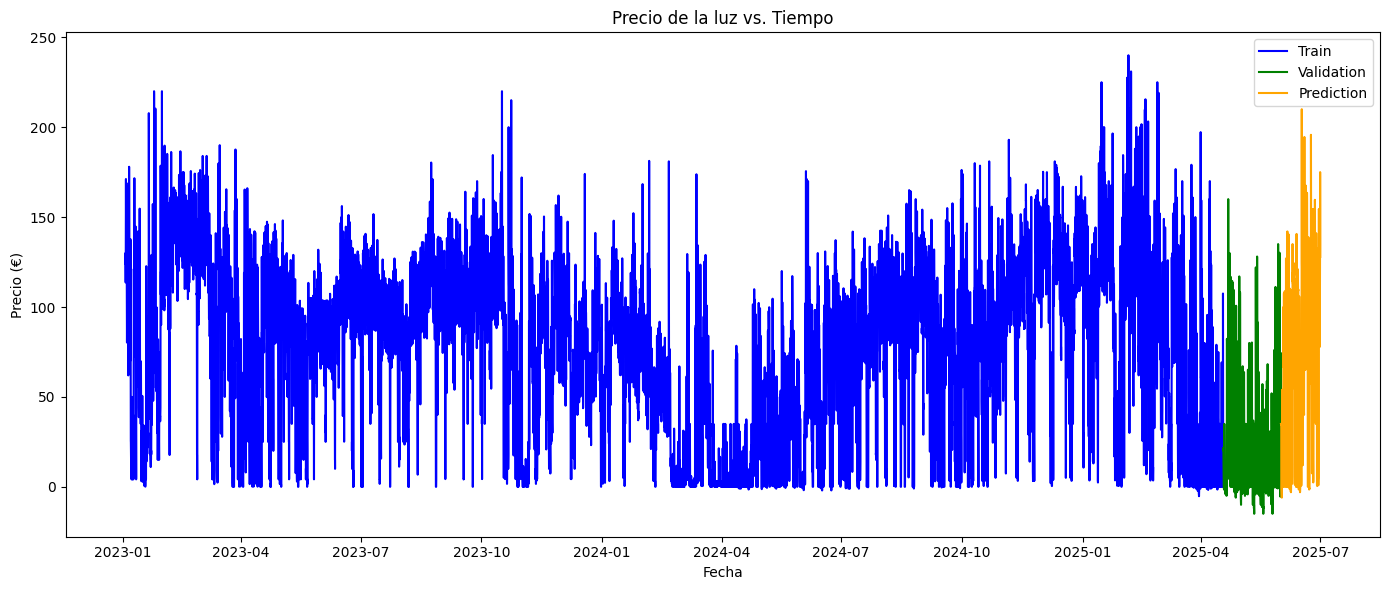

In [5]:
# Graficamos directamente la serie de precios
plt.figure(figsize=(14, 6))
plt.plot(X_train.index, Y_train, label='Train', color='blue')
plt.plot(X_test.index, Y_test, label='Validation', color='green')
plt.plot(X_prediccion.index, Y_prediccion, label='Prediction', color='orange')
plt.title('Precio de la luz vs. Tiempo')
plt.ylabel('Precio (€)')
plt.xlabel('Fecha')
plt.legend()
plt.tight_layout()
plt.show()

Observamos en los boxplots que:
- Las horas valle son al medio día y en los meses de marzo, abril y mayo
- Las horas pico son a primeras horas del día (06:00) y por la tarde (19:00)

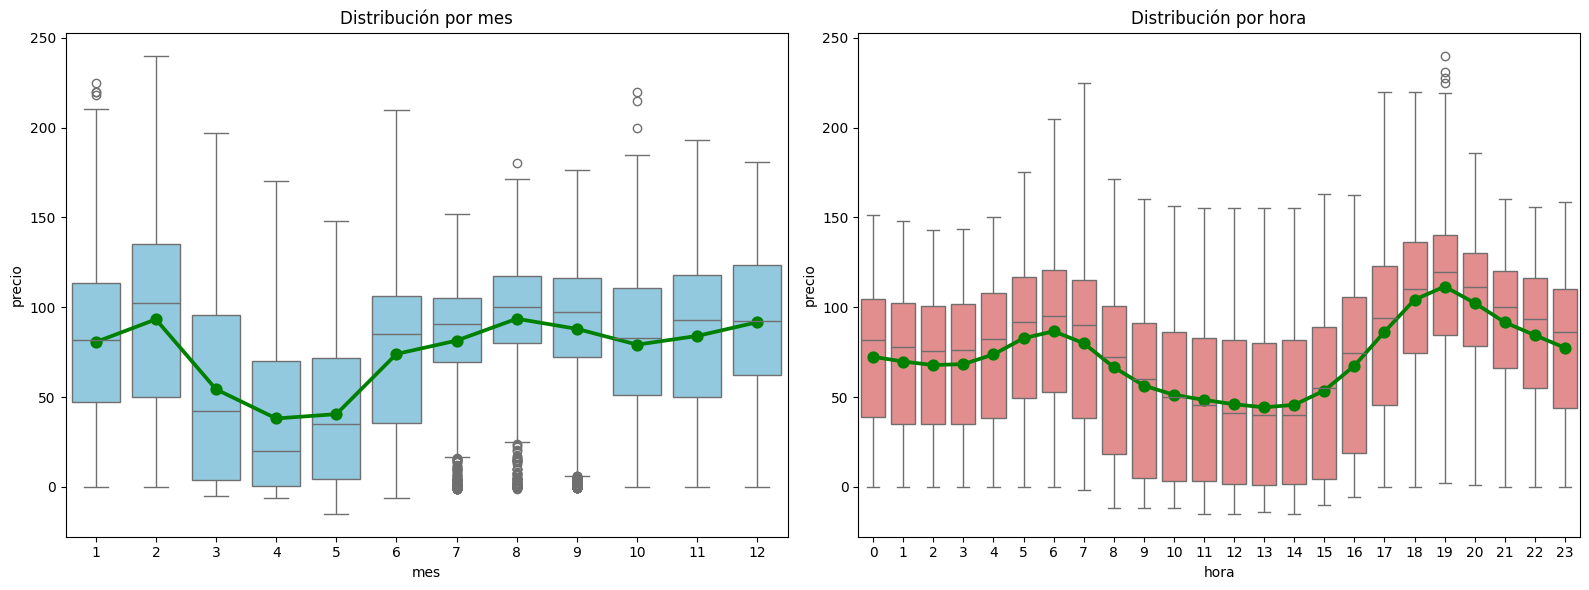

In [6]:
# Boxplots por mes y hora
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
sns.boxplot(x='mes', y='precio', data=df_feat, ax=axs[0], color='skyblue')
sns.pointplot(x='mes', y='precio', data=df_feat, ax=axs[0], estimator='mean', color='green', markers='o', linestyles='-', errorbar=None)
axs[0].set_title("Distribución por mes")
sns.boxplot(x='hora', y='precio', data=df_feat, ax=axs[1], color='lightcoral')
sns.pointplot(x='hora', y='precio', data=df_feat, ax=axs[1], estimator='mean', color='green', markers='o', linestyles='-', errorbar=None)
axs[1].set_title("Distribución por hora")
plt.tight_layout()
plt.show()

La matriz de correlación nos muestra la relación entre las variables, en este caso nos interesa ver que tenemos valores intermedios entre la endógena y las exógenas, sin llegar a extremos cercanos a 1.

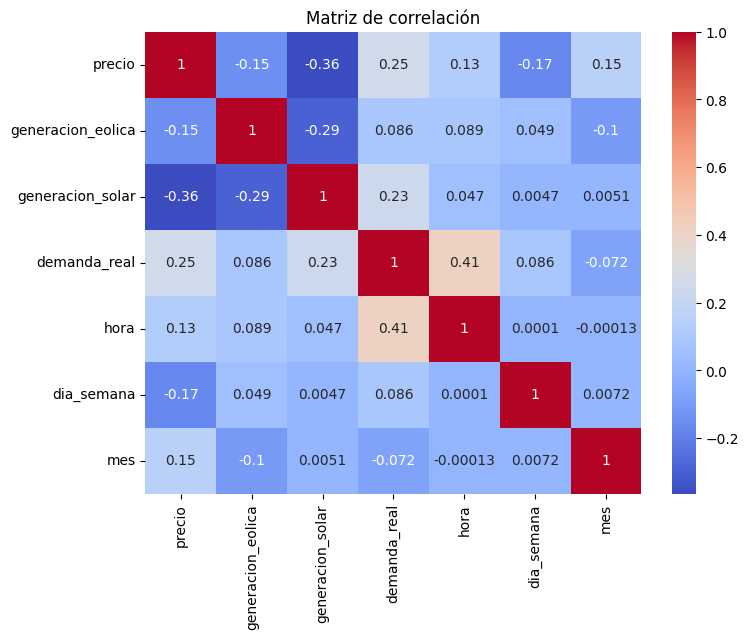

In [7]:
# Matriz de correlación
plt.figure(figsize=(8,6))
sns.heatmap(df_feat[['precio', 'generacion_eolica', 'generacion_solar', 'demanda_real', 'hora', 'dia_semana', 'mes']].corr(), annot=True, cmap='coolwarm')
plt.title('Matriz de correlación')
plt.show()

# Entrenamiendo

## GridSearch + TimeSeriesSplit 

Aplicamos un GridSearch para encontrar los hiperparámetros que mejor funcionan, no introduciendo un gran grado de complejidad para evitar perder generalización en el modelo. El TimeSeriesSplit se utiliza para particionar nuestro conjunto de entrenamiento y realizar sobre éstos los test, de manera que obtenemos errores en diferentes momentos del histórico y podemos promediarlos.

In [10]:
# Hiperparámetros para GridSearch
param_grid = {
    'n_estimators': [100, 250, 500],
    'max_depth': [10, 25, None],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5],
    'max_features': ['sqrt', 'log2', None]
}

tscv = TimeSeriesSplit(n_splits=3)

rf = RandomForestRegressor(random_state=42, n_jobs=-1, oob_score=True)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=tscv,
    n_jobs=1,
    verbose=2
)

print("------------------------------------")
print("Iniciando GridSearchCV para Random Forest...")
print("------------------------------------")
# Entrenar la búsqueda de hiperparámetros
grid_search.fit(X_train, Y_train)
# Obtener mejor modelo
best_model = grid_search.best_estimator_
print("Mejores hiperparámetros:", grid_search.best_params_)

------------------------------------
Iniciando GridSearchCV para Random Forest...
------------------------------------
Fitting 3 folds for each of 162 candidates, totalling 486 fits
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.6s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.9s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=250; total time=   2.2s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=250; total time=   3.2s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=250; total time=   4.3s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50

In [11]:
# Predicciones con el mejor modelo
y_pred_test = best_model.predict(X_test)

## Visualización de los resultados de la búsqueda

c:\Users\alberto.campuzano\Desktop\CasusoPropellers\prediccion-precios-luz\modelos\RandomForest\env_randomforest\Lib\site-packages\sklearn\ensemble\_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\alberto.campuzano\Desktop\CasusoPropellers\prediccion-precios-luz\modelos\RandomForest\env_randomforest\Lib\site-packages\sklearn\ensemble\_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\alberto.campuzano\Desktop\CasusoPropellers\prediccion-precios-luz\modelos\RandomForest\env_randomforest\Lib\site-packages\sklearn\ensemble\_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\alberto.campuzano\Desktop\CasusoPropellers\prediccion-precios-luz\modelos\Rando

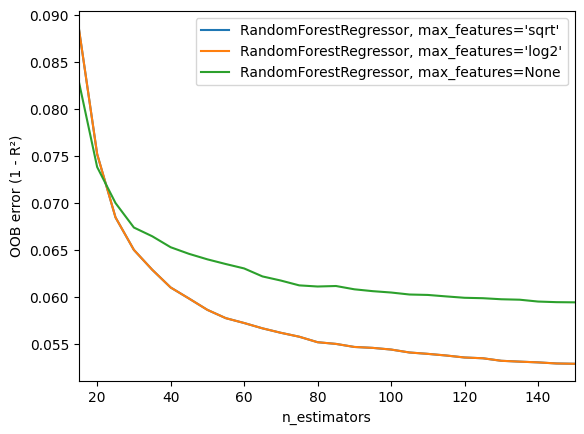

In [12]:
from collections import OrderedDict
# Modelos a comparar según max_features
ensemble_regs = [
    (
        "RandomForestRegressor, max_features='sqrt'",
        RandomForestRegressor(
            warm_start=True,
            oob_score=True,
            bootstrap=True,
            max_features="sqrt",
            random_state=42,
            n_jobs=-1
        ),
    ),
    (
        "RandomForestRegressor, max_features='log2'",
        RandomForestRegressor(
            warm_start=True,
            oob_score=True,
            bootstrap=True,
            max_features="log2",
            random_state=42,
            n_jobs=-1
        ),
    ),
    (
        "RandomForestRegressor, max_features=None",
        RandomForestRegressor(
            warm_start=True,
            oob_score=True,
            bootstrap=True,
            max_features=None,
            random_state=42,
            n_jobs=-1
        ),
    ),
]

# Guardamos errores OOB por número de árboles
error_rate = OrderedDict((label, []) for label, _ in ensemble_regs)

min_estimators = 15
max_estimators = 150

for label, reg in ensemble_regs:
    for i in range(min_estimators, max_estimators + 1, 5):
        reg.set_params(n_estimators=i)
        reg.fit(X_train, Y_train)

        # En regresión, oob_score_ = R² usando datos OOB
        oob_r2 = reg.oob_score_
        oob_error = 1 - oob_r2  # "error" complementario del R²

        # Si prefieres MAE OOB, podrías usar:
        # oob_preds = reg.oob_prediction_
        # oob_error = mean_absolute_error(y_train, oob_preds)

        error_rate[label].append((i, oob_error))

# Graficar error OOB vs n_estimators
for label, reg_err in error_rate.items():
    xs, ys = zip(*reg_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error (1 - R²)")
plt.legend(loc="upper right")
plt.show()

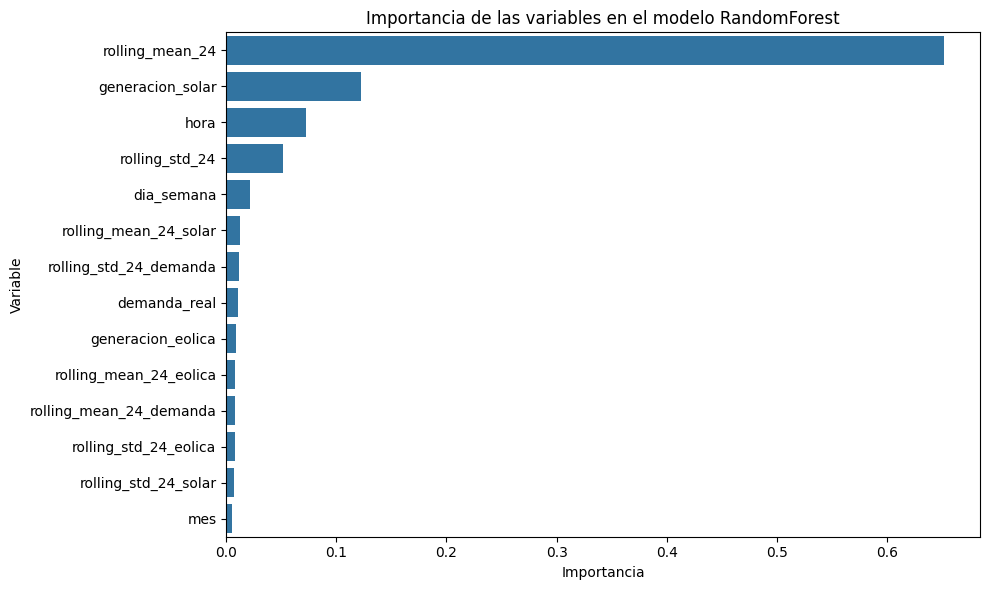

In [13]:
# Importancia de variables
importancia_vars = pd.DataFrame({
    'Variable': X_train.columns,
    'Importancia': best_model.feature_importances_
}).sort_values(by='Importancia', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=importancia_vars, x='Importancia', y='Variable')
plt.title("Importancia de las variables en el modelo RandomForest")
plt.tight_layout()
plt.show()

## Evaluación

In [14]:
# Cálculo de métricas
mae_test = mean_absolute_error(Y_test, y_pred_test)
rmse_test = root_mean_squared_error(Y_test, y_pred_test)
r2_test = r2_score(Y_test, y_pred_test)
print("Resultados en test:")
print(f"MAE: {mae_test:.4f} | RMSE: {rmse_test:.4f} | R2: {r2_test:.4f}")

Resultados en test:
MAE: 10.0862 | RMSE: 14.3840 | R2: 0.7557


## Graficamos el train set con su predicción

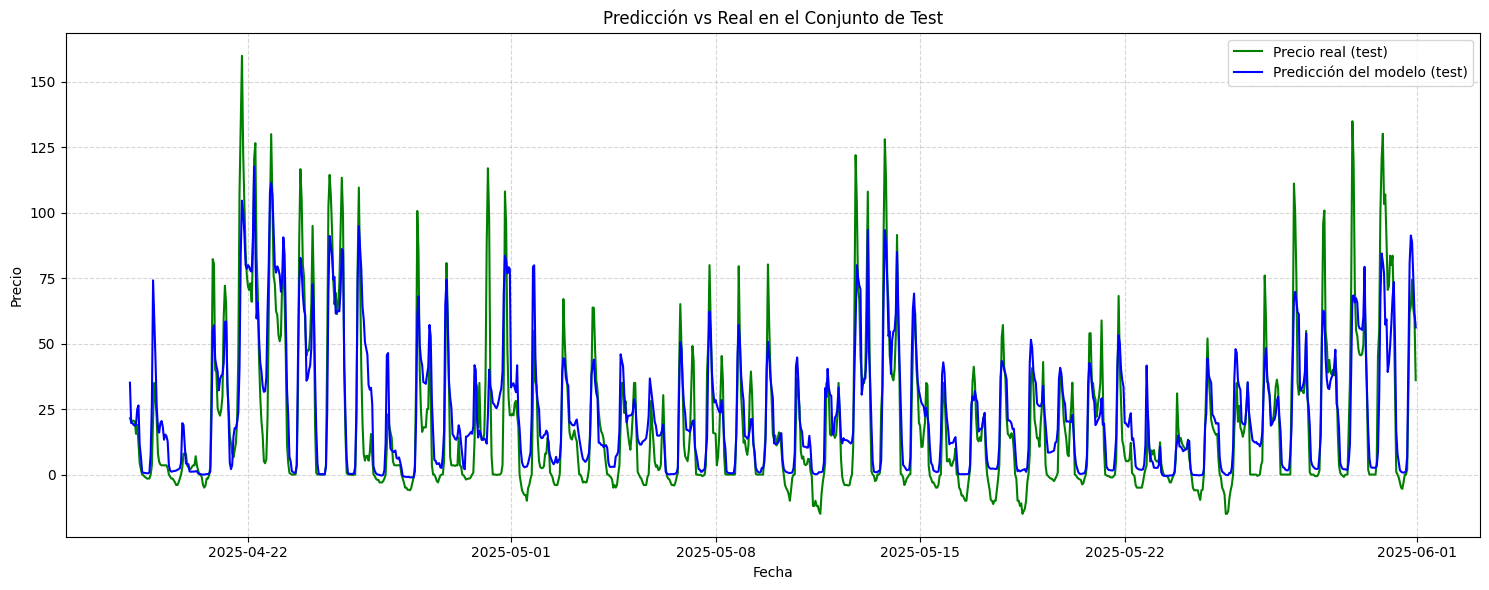

In [15]:
# Graficamos el test set con su predicción
plt.figure(figsize=(15, 6))
plt.plot(Y_test.index, Y_test, label='Precio real (test)', color='green')
plt.plot(Y_test.index, y_pred_test, label='Predicción del modelo (test)', color='blue')
plt.title("Predicción vs Real en el Conjunto de Test")
plt.xlabel("Fecha")
plt.ylabel("Precio")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## Errores en la predicción del conjunto test

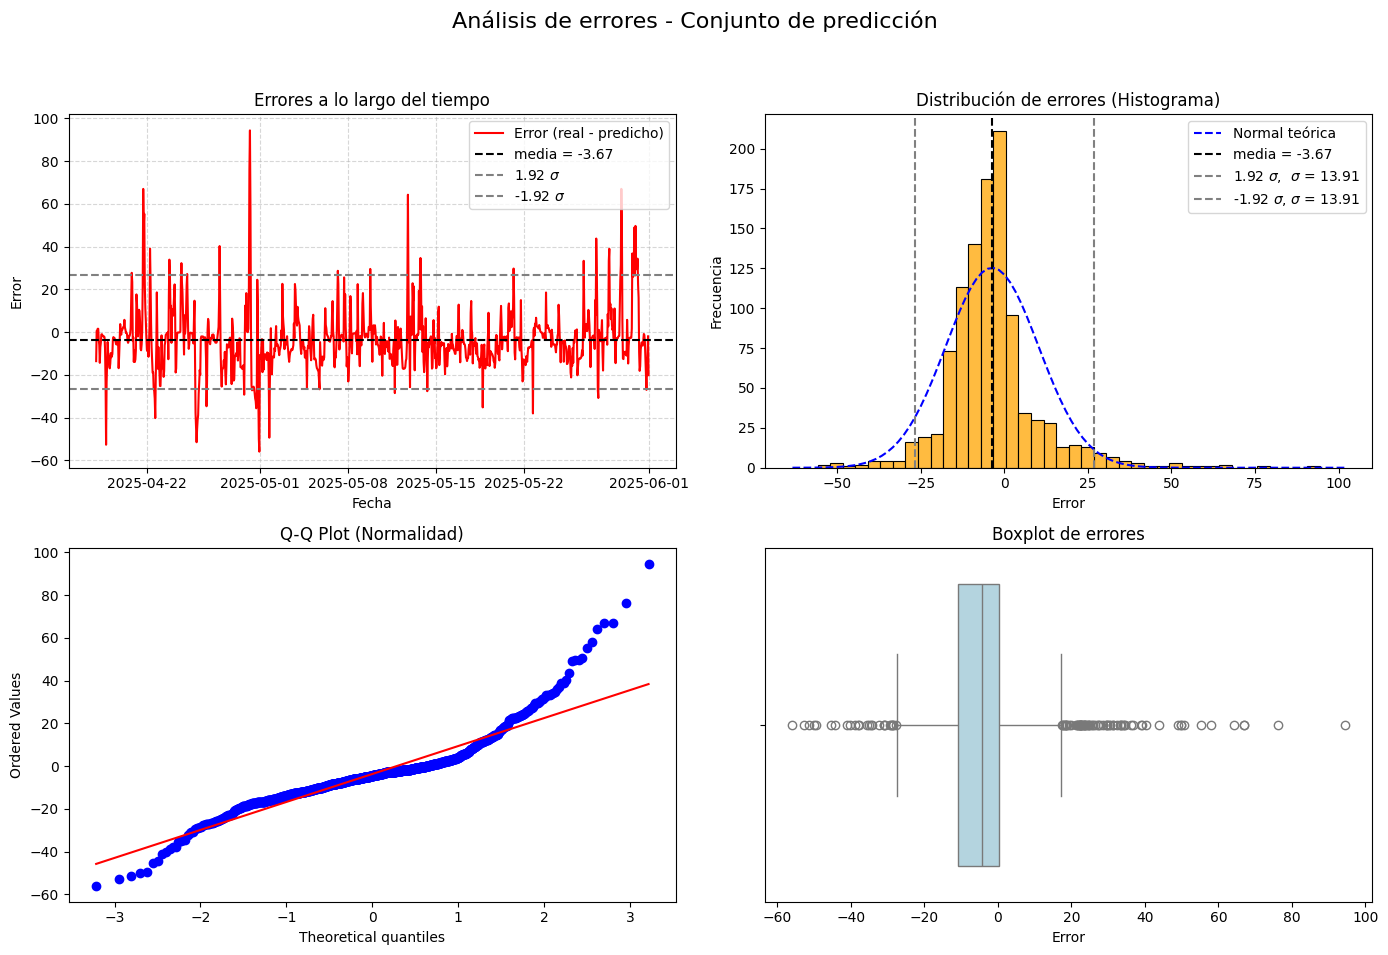

In [16]:
errores_test = Y_test - y_pred_test

media = np.mean(errores_test)
desviacion = np.std(errores_test)

fig, axs = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Análisis de errores - Conjunto de predicción', fontsize=16)

# Gráfica normal
axs[0, 0].plot(errores_test.index, errores_test, color='red', label='Error (real - predicho)')
axs[0, 0].axhline(media, linestyle='--', color='black', label=f"media = {media:.2f}")
axs[0, 0].axhline(1.92*desviacion, linestyle='--', color='grey', label='1.92 $\\sigma$')
axs[0, 0].axhline(-1.92*desviacion, linestyle='--', color='grey', label='-1.92 $\\sigma$')
axs[0, 0].set_title('Errores a lo largo del tiempo')
axs[0, 0].set_xlabel('Fecha')
axs[0, 0].set_ylabel('Error')
axs[0, 0].legend()
axs[0, 0].grid(True, linestyle='--', alpha=0.5)

# Histograma
sns.histplot(errores_test, bins=40, kde=False, color='orange', edgecolor='black', ax=axs[0, 1])
xmin, xmax = axs[0, 1].get_xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, media, desviacion)
axs[0, 1].plot(x, p * len(errores_test) * (xmax-xmin)/40, 'b--', label='Normal teórica')

axs[0, 1].axvline(media, linestyle='--', color='black', label=f"media = {media:.2f}")
axs[0, 1].axvline(1.92*desviacion, linestyle='--', color='grey', label=f'1.92 $\\sigma$,  $\\sigma$ = {desviacion:.2f}')
axs[0, 1].axvline(-1.92*desviacion, linestyle='--', color='grey', label=f'-1.92 $\\sigma$, $\\sigma$ = {desviacion:.2f}')
axs[0, 1].set_title('Distribución de errores (Histograma)')
axs[0, 1].set_xlabel('Error')
axs[0, 1].set_ylabel('Frecuencia')
axs[0, 1].legend()

# Q-Q Plot
stats.probplot(errores_test, dist="norm", plot=axs[1, 0])
axs[1, 0].set_title('Q-Q Plot (Normalidad)')

# Boxplot
sns.boxplot(x=errores_test, color='lightblue', ax=axs[1, 1])
axs[1, 1].set_title('Boxplot de errores')
axs[1, 1].set_xlabel('Error')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# Predicción

In [17]:
best_model.fit(X_total, Y_total)
# Hacemos la predicción
Y_pred = best_model.predict(X_prediccion)

## Evaluamos el modelo

In [18]:
print(" Evaluación sobre el modelo de predicción:")
print("------------------------------------")
print(f"MAE: {mean_absolute_error(Y_prediccion, Y_pred):.4f}")
print(f"RMSE: {root_mean_squared_error(Y_prediccion, Y_pred):.4f}")
print(f"R²: {r2_score(Y_prediccion, Y_pred):.4f}")

 Evaluación sobre el modelo de predicción:
------------------------------------
MAE: 13.3601
RMSE: 18.6411
R²: 0.8684


## Graficamos la prediccion

Podemos generar unos intervalos de confianza a partir de boostraping, esta parte está comentada y es por si se quiere, en la predicción final, implementarlos.

In [21]:
n_bootstraps = 50
bootstrap_preds = np.zeros((len(X_prediccion), n_bootstraps))

for i in range(n_bootstraps):
    X_boot, Y_boot = resample(X_total, Y_total, random_state=i)
    boot_model = RandomForestRegressor(**grid_search.best_params_, random_state=i, n_jobs=-1)
    boot_model.fit(X_boot, Y_boot)
    bootstrap_preds[:, i] = boot_model.predict(X_prediccion)
    print(f"Bootstrap {i+1}/{n_bootstraps}", end='\r')

lower_bound = np.percentile(bootstrap_preds, 2.5, axis=1)
upper_bound = np.percentile(bootstrap_preds, 97.5, axis=1)

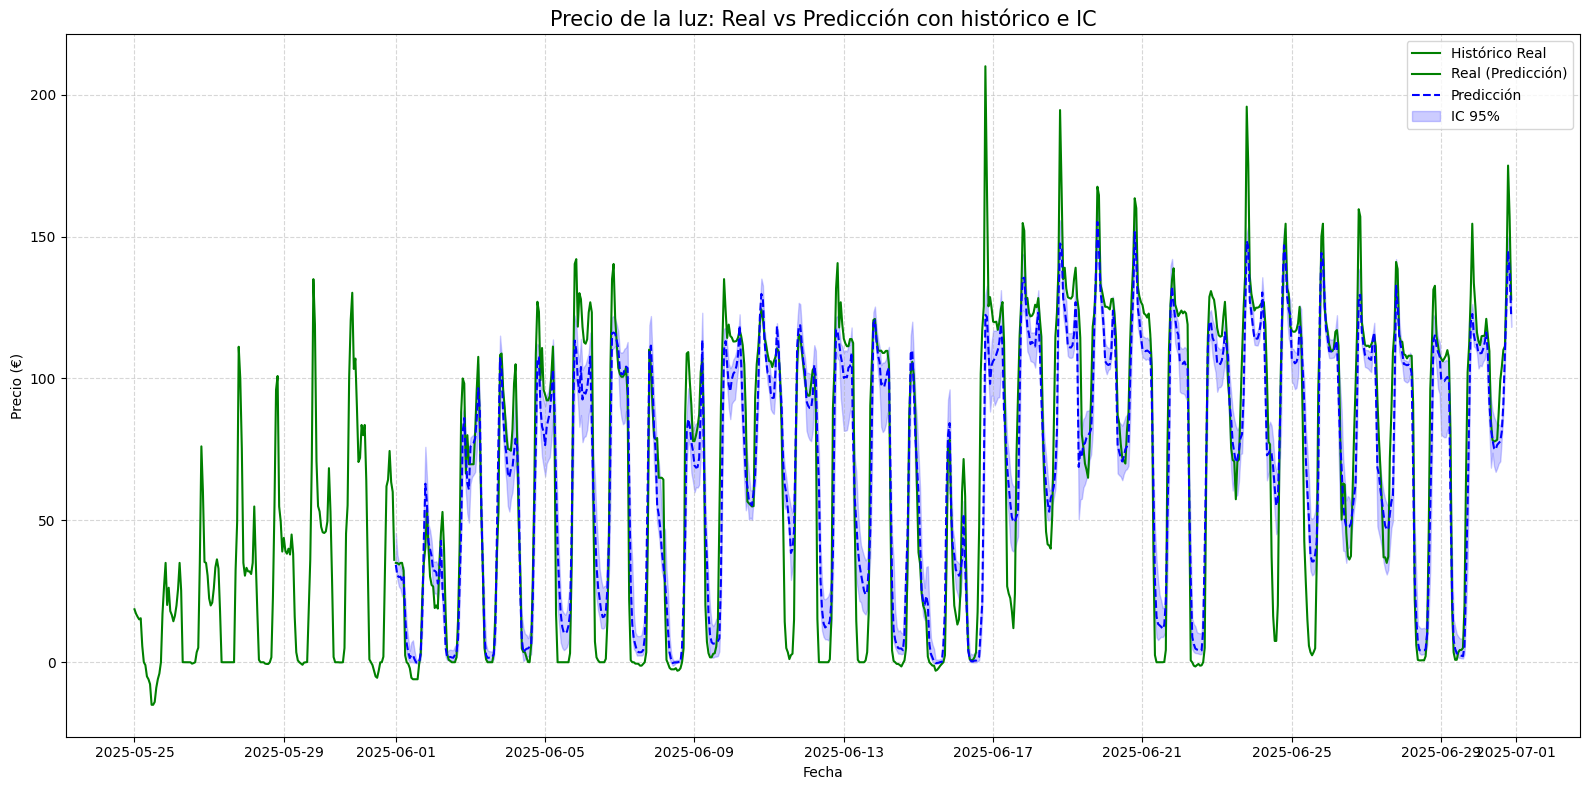

In [22]:
# Grafica de la predicción

dias_historico = 7
inicio_hist = intervalo_prediccion_inicio - pd.Timedelta(days=dias_historico)
historico_real = Y_total.loc[inicio_hist:]

plt.figure(figsize=(16, 8))
plt.plot(historico_real.index, historico_real.values, label='Histórico Real', color='green')
plt.plot(Y_prediccion.index, Y_prediccion.values, label='Real (Predicción)', color='green')
plt.plot(Y_prediccion.index, Y_pred, '--', label='Predicción', color='blue')
plt.fill_between(Y_prediccion.index, lower_bound, upper_bound, color='blue', alpha=0.2, label='IC 95%')
plt.title("Precio de la luz: Real vs Predicción con histórico e IC", fontsize=15)
plt.xlabel("Fecha")
plt.ylabel("Precio (€)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


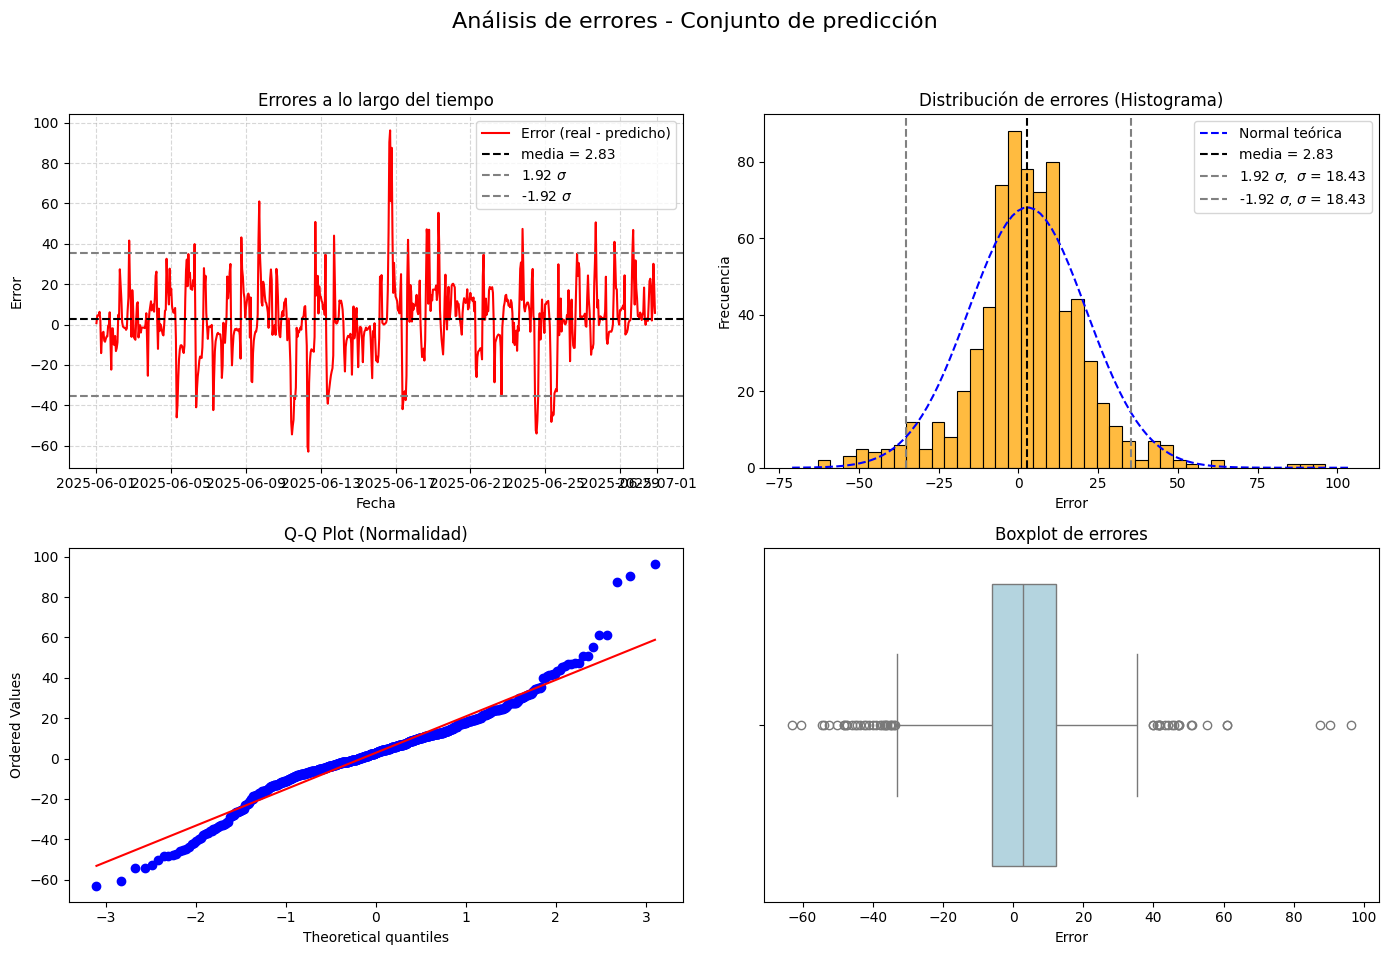

In [23]:
errores_pred = Y_prediccion - Y_pred

media = np.mean(errores_pred)
desviacion = np.std(errores_pred)

fig, axs = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Análisis de errores - Conjunto de predicción', fontsize=16)

# Gráfica normal
axs[0, 0].plot(errores_pred.index, errores_pred, color='red', label='Error (real - predicho)')
axs[0, 0].axhline(media, linestyle='--', color='black', label=f"media = {media:.2f}")
axs[0, 0].axhline(1.92*desviacion, linestyle='--', color='grey', label='1.92 $\\sigma$')
axs[0, 0].axhline(-1.92*desviacion, linestyle='--', color='grey', label='-1.92 $\\sigma$')
axs[0, 0].set_title('Errores a lo largo del tiempo')
axs[0, 0].set_xlabel('Fecha')
axs[0, 0].set_ylabel('Error')
axs[0, 0].legend()
axs[0, 0].grid(True, linestyle='--', alpha=0.5)

# Histograma
sns.histplot(errores_pred, bins=40, kde=False, color='orange', edgecolor='black', ax=axs[0, 1])
xmin, xmax = axs[0, 1].get_xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, media, desviacion)
axs[0, 1].plot(x, p * len(errores_pred) * (xmax-xmin)/40, 'b--', label='Normal teórica')

axs[0, 1].axvline(media, linestyle='--', color='black', label=f"media = {media:.2f}")
axs[0, 1].axvline(1.92*desviacion, linestyle='--', color='grey', label=f'1.92 $\\sigma$,  $\\sigma$ = {desviacion:.2f}')
axs[0, 1].axvline(-1.92*desviacion, linestyle='--', color='grey', label=f'-1.92 $\\sigma$, $\\sigma$ = {desviacion:.2f}')
axs[0, 1].set_title('Distribución de errores (Histograma)')
axs[0, 1].set_xlabel('Error')
axs[0, 1].set_ylabel('Frecuencia')
axs[0, 1].legend()

# Q-Q Plot
stats.probplot(errores_pred, dist="norm", plot=axs[1, 0])
axs[1, 0].set_title('Q-Q Plot (Normalidad)')

# Boxplot
sns.boxplot(x=errores_pred, color='lightblue', ax=axs[1, 1])
axs[1, 1].set_title('Boxplot de errores')
axs[1, 1].set_xlabel('Error')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
